## Описание
Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#data = pd.read_csv('C://Users/79651/toxic_comments.csv')
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.groupby('toxic').describe()

text                                                                
        count  unique                                                top freq
toxic                                                                        
0      143346  143346  Omission of Key Stages \n\nI came to this arti...    1
1       16225   16225  "\nI'm not being cocky, bud. Not all these red...    1

У нас 143346 нетоксичных комментариев и 16225 токсичных.

In [5]:
data['text_len'] = data.text.apply(len)
data.sort_values(by = 'text_len',
ascending = False).head()

,text,toxic,text_len
46583,hahahahahahahahahahahahahahahahahaha vandalism...,1,5000
47715,Block Block Block Block Block Block Block Bloc...,0,5000
74753,Dont Change It!!!! zzzzzzzzzzzzzzzzzzzzzzzzzzz...,0,5000
42061,WANKER WANKER WANKER WANKER WANKER WANKER WANK...,1,5000
72192,China smells like fart. China smells like fart...,1,5000


In [6]:
data.sort_values(by = 'text_len',
ascending = True).head()

,text,toxic,text_len
137062,~ J.Lo,0,6
52442,"14:53,",0,6
109985,{{unbloc,0,8
121074,you suck,1,8
118850,FUCK YOU,1,8


Максимальная длина текста равна 5000 символов. Минимальная - 6 символов.

Text(0.5, 0, 'Длина текста')

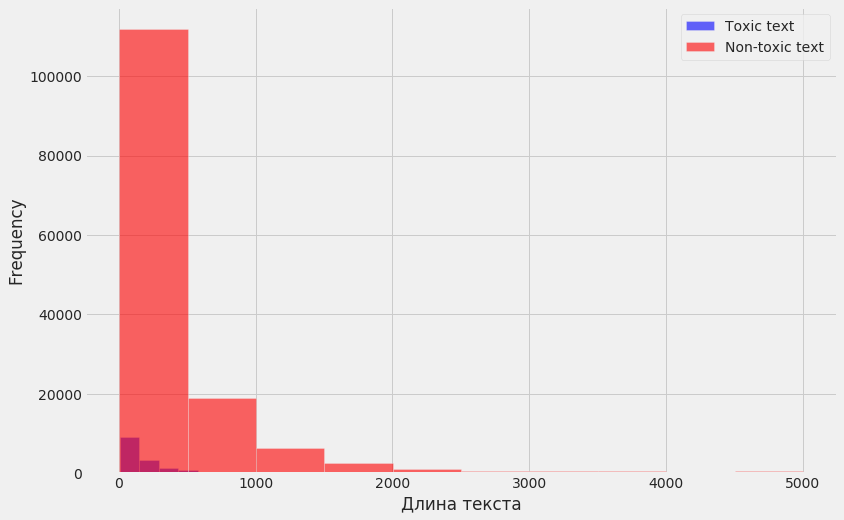

In [7]:
# Посмотрим на распределение по группам:
plt.figure(figsize=(12, 8))

data[data.toxic==1 ].text_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Toxic text', alpha=0.6)
data[data.toxic==0].text_len.plot(kind='hist', color='red', 
                                       label='Non-toxic text', alpha=0.6)
plt.legend()
plt.xlabel("Длина текста")

Очень интересно! Токсичные сообщения в абсолютном большинстве случаев гораздо короче нетоксичных.

In [8]:
data[data.toxic==1].describe()

,toxic,text_len
count,16225.0,16225.000000
mean,1.0,303.304037
std,0.0,619.402896
min,1.0,8.000000
25%,1.0,61.000000
50%,1.0,128.000000
75%,1.0,283.000000
max,1.0,5000.000000


In [9]:
data[data.toxic==0].describe()

,toxic,text_len
count,143346.0,143346.000000
mean,0.0,404.347174
std,0.0,586.503447
min,0.0,6.000000
25%,0.0,102.000000
50%,0.0,216.000000
75%,0.0,452.000000
max,0.0,5000.000000


### Токенизация

In [10]:
# Определим функцию для токенизации:
import string
from nltk.corpus import stopwords

def tokenize(text):
    
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Проверим символы, что они находятся в библиотеке знаков препинания
    nopunc = [char for char in text if char not in string.punctuation]

    # Соединим символы 
    nopunc = ''.join(nopunc)
    
    # Удалим все стоп слова
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [11]:
data['clean_text'] = data.text.apply(tokenize)

In [12]:
data.head()

,text,toxic,text_len,clean_text
0,Explanation\nWhy the edits made under my usern...,0,264,Explanation edits made username Hardcore Metal...
1,D'aww! He matches this background colour I'm s...,0,112,Daww matches background colour seemingly stuck...
2,"Hey man, I'm really not trying to edit war. It...",0,233,Hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,67,sir hero chance remember page thats


In [13]:
# Посмотрим наиболее часто встречающиеся слова в токсичных комментариях:
from collections import Counter

words = data[data.toxic==1].clean_text.apply(lambda x: [word.lower() for word in x.split()])
toxic_words = Counter()

for msg in words:
    toxic_words.update(msg)
    
print(toxic_words.most_common(50))

[('fuck', 8673), ('like', 3767), ('shit', 3653), ('wikipedia', 3481), ('nigger', 3295), ('fucking', 3238), ('suck', 3048), ('go', 2931), ('ass', 2654), ('hate', 2636), ('get', 2428), ('know', 2347), ('page', 2339), ('gay', 2249), ('die', 2136), ('people', 1983), ('fat', 1979), ('faggot', 1965), ('youre', 1914), ('moron', 1885), ('hi', 1709), ('one', 1647), ('cunt', 1557), ('article', 1539), ('stop', 1488), ('stupid', 1476), ('sucks', 1445), ('bitch', 1436), ('think', 1390), ('talk', 1378), ('pig', 1349), ('jew', 1349), ('want', 1305), ('dick', 1215), ('wiki', 1169), ('time', 1168), ('bullshit', 1163), ('would', 1150), ('block', 1142), ('even', 1133), ('life', 1121), ('make', 1050), ('wanker', 1035), ('cant', 1034), ('see', 1033), ('edit', 1030), ('please', 1027), ('fag', 1015), ('right', 1014), ('going', 1012)]


In [14]:
# Посмотрим наиболее часто встречающиеся слова в нетоксичных комментариях:
words = data[data.toxic==0].clean_text.apply(lambda x: [word.lower() for word in x.split()])
nontoxic_words = Counter()

for msg in words:
    nontoxic_words.update(msg)
    
print(nontoxic_words.most_common(50))

[('article', 53852), ('page', 43265), ('wikipedia', 32045), ('talk', 29514), ('please', 28572), ('would', 28060), ('one', 26393), ('like', 23935), ('see', 20448), ('also', 19717), ('think', 18645), ('articles', 16940), ('know', 16638), ('edit', 16546), ('use', 15809), ('people', 15691), ('may', 15203), ('time', 14210), ('thanks', 13315), ('even', 12238), ('make', 11888), ('good', 11743), ('information', 11504), ('could', 11466), ('well', 11068), ('sources', 10969), ('get', 10913), ('deletion', 10701), ('name', 10456), ('way', 10382), ('pages', 10323), ('want', 10297), ('first', 10294), ('help', 10209), ('new', 10047), ('source', 9888), ('section', 9785), ('editing', 9638), ('thank', 9617), ('need', 9489), ('say', 9261), ('edits', 9150), ('made', 9070), ('many', 9026), ('user', 8897), ('used', 8884), ('much', 8857), ('discussion', 8801), ('find', 8561), ('deleted', 8552)]


Слова 'wikipedia' и 'like'находятся в топе и там и там. 

### Векторизация

In [15]:
data.head()

,text,toxic,text_len,clean_text
0,Explanation\nWhy the edits made under my usern...,0,264,Explanation edits made username Hardcore Metal...
1,D'aww! He matches this background colour I'm s...,0,112,Daww matches background colour seemingly stuck...
2,"Hey man, I'm really not trying to edit war. It...",0,233,Hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,67,sir hero chance remember page thats


In [16]:
X = data.clean_text
y = data.toxic
print(X.shape)
print(y.shape)

(159571,)
(159571,)


In [17]:
# Разделим данные на обучающую, валидационнуюю и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)


(95742,)
(31914,)
(31915,)
(95742,)
(31914,)
(31915,)


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
# Создадим счётчик:
vect = CountVectorizer(stop_words='english', min_df=2, max_df=0.5)
vect.fit(X_train)# Изучим словарь всех токенов в необработанных документах

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.5, max_features=None, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [19]:
# Преобразуем данные Преобразование документов в document-term matrix. 
#Метод вернёт матрицу, в которой одна строка — это текст, а столбец —
#уникальное слово из всего корпуса. Число на их пересечении покажет,
#сколько раз в тексте встречалось нужное слово
X_train_dtm = vect.transform(X_train)

In [20]:
# Изучим document-term matrix
X_train_dtm

<95742x60242 sparse matrix of type '<class 'numpy.int64'>'
	with 2228697 stored elements in Compressed Sparse Row format>

In [21]:
# Преобразуем другие выборки в document-term matrix
X_valid_dtm = vect.transform(X_valid)
X_valid_dtm

<31914x60242 sparse matrix of type '<class 'numpy.int64'>'
	with 732951 stored elements in Compressed Sparse Row format>

In [22]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<31915x60242 sparse matrix of type '<class 'numpy.int64'>'
	with 729539 stored elements in Compressed Sparse Row format>

### TF-IDF в sklearn

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tf_idf = tfidf_transformer.fit_transform(X_train_dtm)#Функцию fit() запускаем только на обучающей
X_valid_tf_idf = tfidf_transformer.transform(X_valid_dtm)
X_test_tf_idf = tfidf_transformer.transform(X_test_dtm)

In [24]:
X_train_dtm

<95742x60242 sparse matrix of type '<class 'numpy.int64'>'
	with 2228697 stored elements in Compressed Sparse Row format>

Функцию fit() запускаем только на обучающей. Иначе тестирование будет нечестным: в модели будут учтены частоты слов из тестовой выборки.

# 2. Обучение

### MultinomialNB

Наивный байесовский классификатор для многомерных моделей.

Мультиномиальный наивный байесовский классификатор подходит для классификации с дискретными признаками (например, количество слов для классификации текста). Мультиномиальное распределение обычно требует подсчета целых объектов. Однако на практике дробные подсчеты, такие как tf-idf, также могут работать.

In [25]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [26]:
%time nb.fit(X_train_tf_idf, y_train)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 52.9 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
y_pred_class = nb.predict(X_valid_tf_idf)

In [28]:
from sklearn import metrics
from sklearn.metrics import f1_score
f1_score(y_valid, y_pred_class)

0.477681701332087

In [29]:
metrics.confusion_matrix(y_valid, y_pred_class)

array([[28657,    13],
       [ 2222,  1022]])

In [30]:
X_valid.shape

(31914,)

In [31]:
# Посмотрим на ложноположительные срабатывания:
X_valid[y_pred_class > y_valid]

14550     Origin Utigur Huns Roman historians Themistius...
831                             OH GET LIFE PRICK 811441992
57354                        notthe decider haha hillarious
81634                                 Oohh Obviously retard
106411                                        aka suck life
133701    voidid whatever name hey voidid called nobody ...
12716                               Urrrppp wanna love Burp
73817                         Indeed Flame douchebag —T C W
74704                                               wtf TCE
126659                                 like hoe 10119015184
129477                              never smell nerd cloaca
27918                                           lesbian gay
62215     CalendarWatcher pedophile child molester compu...
Name: clean_text, dtype: object

In [32]:
# Посмотрим на ложноотрицательные срабатывания:
X_valid[y_pred_class < y_valid]

112199    Reverting reason spent quite time improving ar...
101482    LEAVE ALONE Stop trying tell dictate words cho...
57105     clarification youre cock Congrats software det...
6180      believe Sources said shit get pot Meanwhile le...
67572     ha ha little racist protector cant deal called...
                                ...                        
29991     one thinks Zappas dad Arab Greek descent inacc...
32044     cant block liveif block come round house rape ass
33661                                   SCONES COOL ARD GAY
126603                                             genitals
4580      PAGE 3234434aAa mean OLD BULLSHITTING fartas w...
Name: clean_text, Length: 2222, dtype: object

В принципе не такие уж и токсичные предложения на первый взгляд.

### Логистическая регрессия

In [33]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()

In [34]:
%time lg.fit(X_train_tf_idf, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 3.24 s, sys: 4.36 s, total: 7.6 s
Wall time: 7.63 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
y_pred_class = lg.predict(X_valid_tf_idf)

In [36]:
f1_score(y_valid, y_pred_class)

0.711534795042898

F1_score гораздо лучше, чем MultinomialNB

In [37]:
metrics.confusion_matrix(y_valid, y_pred_class)

array([[28535,   135],
       [ 1378,  1866]])

### XGBClassifier

In [38]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [39]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=500)
%time xgb.fit(X_train_tf_idf, y_train)
y_pred_class = xgb.predict(X_valid_tf_idf)
f1_score(y_valid, y_pred_class)


CPU times: user 3min 24s, sys: 96 ms, total: 3min 24s
Wall time: 3min 25s


0.6913388878124394

### RandomForestClassifier

In [40]:
# Подберем наилучшие параметры:
from sklearn.ensemble import RandomForestClassifier

for estim in range(50,101,25):
    rfc = RandomForestClassifier(random_state=12345, n_estimators=estim)
    rfc.fit(X_train_tf_idf, y_train)
    y_pred_class = rfc.predict(X_valid_tf_idf)
    score = f1_score(y_valid, y_pred_class)
    print("n_estimators =", estim, "; ", end='')
    print("F1 =", score)
    print("-------------------------------")

n_estimators = 50 ; F1 = 0.7434930892119908
-------------------------------
n_estimators = 75 ; F1 = 0.7481323372465316
-------------------------------
n_estimators = 100 ; F1 = 0.7441860465116279
-------------------------------


Лучшая модель оказалась RandomForestClassifier с 75 оценщиками.

# Тестирование модели

In [41]:
# Для более лучшего обучения объединим обучающую и валидационную выборки:
X_full = pd.concat([X_train] + [X_valid])
y_full = pd.concat([y_train] + [y_valid])

vect.fit(X_full)
X_full_dtm = vect.transform(X_full)
X_test_dtm = vect.transform(X_test)

X_full_tf_idf = tfidf_transformer.fit_transform(X_full_dtm)#Функцию fit() запускаем только на обучающей
X_test_tf_idf = tfidf_transformer.transform(X_test_dtm)

In [42]:
# Обучим заново модель на объединенной выборке и проверим качество на тестовой выборке
rfc = RandomForestClassifier(random_state=12345, n_estimators=75)
rfc.fit(X_full_tf_idf, y_full)
y_pred_class = rfc.predict(X_test_tf_idf)


In [43]:
print('F1 = {:.2f}'.format(f1_score(y_test, y_pred_class)))

F1 = 0.75


Отлично! Мы справились с поставленной задачей. F1 не меньше 0.75